In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import json
from collections import defaultdict 
import sys
sys.path.append("..")
from helpers import kg_to_json


In [12]:


def buildGraphFromNER(file):
    """
    Input:
        string: NER file name
    Return:
        knowledgeGraph: networkx.Graph object, the knowledge graph with entities as nodes and ocurrence as edge weights
        entitySource: dict, map from entities to source cord_id
        souceEntity: dict, map from source cord_id to entities
    """
    entitySource = defaultdict(set)
    souceEntity = defaultdict(set)
    legalLabels = ['DRUG', 'CHEMICAL', 'DISEASE']
    fi = open(file)
    knowledgeGraph = nx.Graph()
    line = fi.readline()
    while line:
#         if "ajlctjeb" in line:
#             break
        words = line.strip().split('#')
        cord_uid = words[0]
        entities = set()
        labels = {}
        for index in range((len(words)-1)//3):
            entity = words[1+3*index]
            label = words[2+3*index]
            if label not in legalLabels:
                continue
            location = words[3+3*index]
            entities.add(entity)
            labels[entity] = label
        knowledgeGraph.add_nodes_from([(label, {"label":labels[label]}) for label in labels])
        
        souceEntity[cord_uid] = entities
        entities = list(entities)
        entSize = len(entities)
        for i in range(entSize):
            for j in range(i+1, entSize):
                if knowledgeGraph.has_edge(entities[i], entities[j]):
                    # we added this one before, just increase the weight by one
                    knowledgeGraph[entities[i]][entities[j]]['weight'] += 1
                else:
                    # new edge. add with weight=1
                    knowledgeGraph.add_edge(entities[i], entities[j], weight=1)
            entitySource[entities[i]].add(cord_uid)
        line = fi.readline()
    fi.close()
    return knowledgeGraph,entitySource,souceEntity
    

# Build knowledge graph from Med7 NER results

In [7]:
file = "../data/ner_abstract/med7_lemma_abbr_abstract.txt"
med7Graph, med7Ent2Souce, med7Souce2Ent = buildGraphFromNER(file)
#print(med7Graph['remdesivir'][:10)

In [8]:
print("number of nodes", med7Graph.number_of_nodes())
print("number of edges", med7Graph.number_of_edges())

number of nodes 38097
number of edges 240123


# Build knowledge graph from bc5cdr NER results


In [9]:
file = "../data/ner_abstract/en_ner_bc5cdr_md_lemma_abbr_abstract.txt"
bc5cdrGraph, bc5cdrEnt2Souce, bc5cdrSouce2Ent = buildGraphFromNER(file)

In [10]:
print("number of nodes", bc5cdrGraph.number_of_nodes())
print("number of edges", bc5cdrGraph.number_of_edges())

number of nodes 115278
number of edges 1896274


In [11]:
print(bc5cdrGraph['fever']['remdesivir'])

{'weight': 3}


In [13]:
def pruningGraph(graph, threshold):
    """
    Input:
        graph: networkx.Graph object
        threshold: int
    Return
        graph: networkx.Graph object. Edges whose weight < threshold are pruned. So are isolated nodes
    """
    remove = [(u,v) for u,v,e in graph.edges(data=True) if e['weight'] < threshold]
    graph.remove_edges_from(remove)
    graph.remove_nodes_from(list(nx.isolates(graph)))
    return graph

In [18]:
threshold = 3
prunedMed7Graph = pruningGraph(med7Graph, threshold)
print("Pruned Med7 Graph:")
print("number of nodes", prunedMed7Graph.number_of_nodes())
print("number of edges", prunedMed7Graph.number_of_edges())
#print(prunedMed7Graph['remdesivir'])

Pruned Med7 Graph:
number of nodes 3079
number of edges 11373


In [19]:
threshold = 3
prunedbc5cdrGraph = pruningGraph(bc5cdrGraph, threshold)
print("Pruned bc5cdr Graph:")
print("number of nodes", prunedbc5cdrGraph.number_of_nodes())
print("number of edges", prunedbc5cdrGraph.number_of_edges())

Pruned bc5cdr Graph:
number of nodes 16121
number of edges 150965


In [20]:
print(prunedbc5cdrGraph['fever']['remdesivir'])

{'weight': 3}


# Build the knowledge graph on both NER results

In [23]:
def combined_graphs_edges(Souce2Ent1, Souce2Ent2):
    """
    Input:
        Souce2Ent1: dict, map from source cord_id to entities
        Souce2Ent2: dict, map from source cord_id to entities
    Return:
        knowledgeGraph: networkx.Graph object, a knowledge graph built on two NER results
    """
    knowledgeGraph = nx.Graph()
    combinedSouce2Ent = defaultdict(set)
    for cord_uid in Souce2Ent1:
        combinedSouce2Ent[cord_uid].update(Souce2Ent1[cord_uid])
    for cord_uid in Souce2Ent2:
        combinedSouce2Ent[cord_uid].update(Souce2Ent2[cord_uid])
    for cord_uid in combinedSouce2Ent:
        entities = list(combinedSouce2Ent[cord_uid])
        entSize = len(entities)
        for i in range(entSize):
            for j in range(i+1, entSize):
                if knowledgeGraph.has_edge(entities[i], entities[j]):
                    knowledgeGraph[entities[i]][entities[j]]['weight'] += 1
                else:
                    knowledgeGraph.add_edge(entities[i], entities[j], weight=1)
    return knowledgeGraph
#     combined = G.copy()
#     for u,v,e in H.edges(data=True):
#         if combined.has_edge(u,v):
#             combined[u][v]['weight'] += e['weight']
#         else:
#             combined.add_edge(u,v, weight = e['weight'])
#     return combined



In [22]:
combinedGraph=combined_graphs_edges(med7Souce2Ent,bc5cdrSouce2Ent)
print("number of nodes", combinedGraph.number_of_nodes())
print("number of edges", combinedGraph.number_of_edges())

number of nodes 143295
number of edges 2797343


In [24]:
print(combinedGraph['fever']['remdesivir'])

{'weight': 70}


# Prune the edges whose weight <3

In [25]:
threshold = 3
prunedCombinedGraph = pruningGraph(combinedGraph, threshold)
print("The combined graph after pruning:")
print("number of nodes", prunedCombinedGraph.number_of_nodes())
print("number of edges", prunedCombinedGraph.number_of_edges())

The combined graph after pruning:
number of nodes 16932
number of edges 147797


# Visualize a subgraph in the combined graph

(entity1, entity2, edge weight)
(pneumonia, fever, 1113)
(pneumonia, headache, 122)
(pneumonia, cough, 679)
(pneumonia, diarrhea, 190)
(pneumonia, remdesivir, 93)
(pneumonia, hydroxychloroquine, 175)
(remdesivir, hydroxychloroquine, 313)
(remdesivir, cough, 36)
(remdesivir, fever, 70)
(remdesivir, headache, 3)
(remdesivir, diarrhea, 4)
(cough, fever, 2569)
(cough, diarrhea, 396)
(cough, headache, 375)
(cough, hydroxychloroquine, 157)
(headache, fever, 507)
(headache, diarrhea, 181)
(headache, hydroxychloroquine, 23)
(fever, diarrhea, 624)
(fever, hydroxychloroquine, 235)
(hydroxychloroquine, diarrhea, 54)


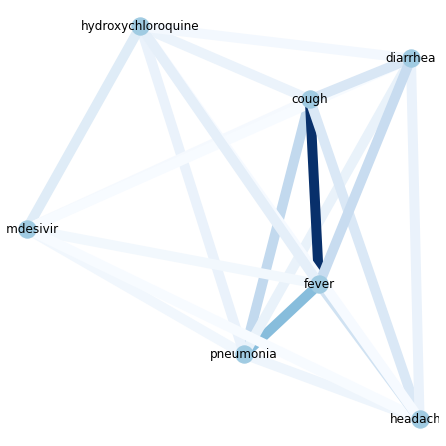

In [27]:
H = combinedGraph.subgraph(['fever','cough','headache','pneumonia','diarrhea', 'hydroxychloroquine','remdesivir'])
colors = []
print("(entity1, entity2, edge weight)")
for (u, v, wt) in H.edges.data('weight'):
    print(f"({u}, {v}, {wt})")
    colors.append(wt)
pos = nx.spring_layout(H)
#colors = range(len(H.edges))
options = {
    "node_color": "#A0CBE2",
    "edge_color": colors,
    "width": 10,
    "edge_cmap": plt.cm.Blues,
    "with_labels": True,
}
plt.figure(figsize=(6,6))
nx.draw(H, pos, **options)
kg_to_json(combinedGraph, "kg_results/full_kg.json")
kg_to_json(prunedCombinedGraph, "kg_results/full_kg_pruned.json")
plt.show()